In [1]:
import pandas as pd
import numpy as np
from gravity_utils import *
import datetime

In [2]:
pd.set_option('display.max_rows', 1398)
pd.set_option('display.max_columns', 1398)

In [3]:
import shapefile
import shapely.wkt

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [5]:
def print_stats (model, X, y):
    """Prints coefficients, t-values and probabilities P value?"""
    lm = model
#     params = np.append(lm.intercept_,lm.coef_)
    params = lm.coef_
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
#     newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    newX = pd.DataFrame(X.reset_index(drop=True))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,5)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
#     myDF3.index = np.append(['intercept_'], X.columns.values)
    myDF3.index = X.columns.values
    print(myDF3)

In [6]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [7]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 

# attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
# production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

# production_rvu_sams = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
# attraction_rvu_sams = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [8]:
resfil_tours_raw = resfil_raw[resfil_raw['ärende_2'] == 1].drop_duplicates(subset=['Id'], keep='first')
upsampled_resfil_tours = draw_population(resfil_tours_raw, resfil_tours_raw.individvikt.astype(int))

attraction_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [9]:
production_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf1_komkod'] < 2000) &
                                (resfil_tours_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf4_komkod'] < 2000) &
                                (resfil_tours_raw['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [10]:
rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

# sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
# sams_index = sams_ids.index
sams_index = sams_w_nbuildings.SAMSCODE.values

In [11]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').loc[sams_index].reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').loc[sams_index].reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').loc[sams_index].reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [12]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [13]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.loc[sams_index].sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


In [14]:
other_trip_scb_2018 = pd.read_csv('data/coomuting_municipalities_2018.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2018['production'] = other_trip_scb_2018['Outgoing commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2018['attraction'] = other_trip_scb_2018['Incomming commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2003 = pd.read_csv('data/coomuting_municipalities_2013.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2003['production'] = other_trip_scb_2003['Comuters leaving the municipality'] + other_trip_scb_2003['Working and living in the municipality']
other_trip_scb_2003['attraction'] = other_trip_scb_2003['Comuters coming into the municipality'] + other_trip_scb_2003['Working and living in the municipality']

In [15]:
other_trip_scb_2003 = other_trip_scb_2003.dropna()
other_trip_scb_2018 = other_trip_scb_2018.dropna()

In [16]:
other_trip_scb_raw = \
pd.concat([other_trip_scb_2018.production - (other_trip_scb_2018.production - other_trip_scb_2003.production)*5/15,
           other_trip_scb_2018.attraction - (other_trip_scb_2018.attraction - other_trip_scb_2003.attraction)*5/15,
           other_trip_scb_2018['Outgoing commuters'] - (other_trip_scb_2018['Outgoing commuters'] - other_trip_scb_2003['Comuters leaving the municipality'])*5/15,
           other_trip_scb_2018['Incomming commuters'] - (other_trip_scb_2018['Incomming commuters'] - other_trip_scb_2003['Comuters coming into the municipality'])*5/15,
           other_trip_scb_2018['Work and live in county/municipality'] - (other_trip_scb_2018['Work and live in county/municipality'] - other_trip_scb_2003['Working and living in the municipality'])*5/15,
          ],
         axis=1)
other_trip_scb_raw.columns=['production', 'attraction', 'outgoing', 'incomming', 'within']

In [17]:
other_trip_scb_raw

,production,attraction,outgoing,incomming,within
County/Municipality,,,,,
1214,6420.666667,3998.666667,4008.333333,1586.333333,2412.333333
1230,11115.000000,6318.333333,8450.666667,3654.000000,2664.333333
1231,7476.333333,8257.000000,5501.000000,6281.666667,1975.333333
1233,16125.333333,8499.000000,11189.666667,3563.333333,4935.666667
1256,6280.333333,4848.666667,2911.333333,1479.666667,3369.000000
1257,4457.000000,3883.000000,1910.333333,1336.333333,2546.666667
1260,6609.333333,4803.666667,4040.666667,2235.000000,2568.666667
1261,14433.333333,7940.000000,9982.666667,3489.333333,4450.666667
1262,10470.000000,5527.000000,8099.000000,3156.000000,2371.000000


In [18]:
avg_day_c = production_kommun_rvu.sum() / other_trip_scb_raw.production.sum()
avg_day_c
other_trip_scb = other_trip_scb_raw*avg_day_c

In [19]:
avg_day_c

0.651633045730121

# Production linear regression

In [20]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

# lin = LinearRegression(fit_intercept=False, )

x_prod = other_x_sams.drop(axis=1, labels=['OffentligaA4','Ald25_44','TotBef', 'appt_build','multi_appartment_building','small_building','Ald65_W','Ald45_64','TotaltA2','Ald20_24','nIndustri','nEkonomi','TotaltA4','Ald16_19','Ald7_15','Ald0_6','nProduction','nAttraction','SAMSCODE'])
y_prod = other_trip_scb.production

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

# x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

R**2 value
0.9998860706634678
              Coefficients  Standard Errors  t values  Probabilites
OffentligaA2        0.5158            0.018    28.324       0.00000
NaringslivA2        0.6993            0.010    68.610       0.00000
NaringslivA4        0.0372            0.008     4.939       0.00002


In [21]:
pred_prod_sams = pd.DataFrame(
    production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)

In [22]:
pred_prod_sams.describe()

,trips
count,1397.000000
mean,271.495619
std,291.146924
min,0.000000
25%,66.158824
50%,184.282246
75%,371.860304
max,2377.125475


In [23]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_prod_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.production)

In [24]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.production)

0.9998854928896254

In [25]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.production).describe()

count    33.000000
mean      1.012254
std       0.020275
min       0.986399
25%       0.997900
50%       1.008151
75%       1.021808
max       1.056983
dtype: float64

# Attraction Linear regression

In [26]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef', 'SAMSCODE', 'Ald0_6', 'nProduction', 'nAttraction', 'multi_appartment_building', 'small_building', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'Ald7_15', 'Ald16_19', 'Ald20_24','appt_build', 'Ald65_W', 'Ald45_64','TotaltA4', 'nEkonomi'])
y_att = other_trip_scb.attraction

# x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.9997709289511443
              Coefficients  Standard Errors  t values  Probabilites
Ald25_44            0.2051            0.029     7.003       0.00000
nIndustri           0.9510            0.197     4.833       0.00003
OffentligaA4        0.6471            0.025    25.617       0.00000
NaringslivA4        0.5360            0.026    20.234       0.00000


In [27]:
pred_att_sams = pd.DataFrame(
    attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, X_att.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)
pred_att_sams.describe()

,trips
count,1397.000000
mean,267.022473
std,454.666141
min,0.000000
25%,52.485378
50%,133.370841
75%,310.093441
max,5985.384590


In [28]:
pred_att_sams.loc[12650000:12659999].sum()

trips    4208.86583
dtype: float64

In [29]:
y_att[1265]

3975.3960009842253

In [30]:
pred_prod_sams.loc[12650000:12659999].sum()

trips    5962.677432
dtype: float64

In [31]:
y_prod[1265]

5729.157738059224

In [32]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_att_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.attraction)

In [33]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.attraction)

0.9997693393236631

In [34]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.attraction).describe()

count    33.000000
mean      1.028054
std       0.052064
min       0.906502
25%       0.986583
50%       1.033069
75%       1.064003
max       1.153474
dtype: float64

# Gravity model for municipalities

# Gravity

In [35]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix_with_kommun.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [36]:
# sams_distance_matrix.replace(0, np.nan, inplace=True)
# for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[[1273, 1291], [1273, 1291]].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)

# sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (1.0 / 3)
# sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (1.0 / 3)
# sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (1.0 / 3)
# sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (1.0 / 3)
    
r = 4000
r1 = 4000
for (idx, value) in sams_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r
for (idx, value) in sams_distance_matrix.loc[12650000:12659999, 12650000:12659999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = r1
sams_distance_matrix.at[12650001, 12650002] = r
sams_distance_matrix.at[12650002, 12650001] = r
sams_distance_matrix.at[12700020, 12700001] = r
sams_distance_matrix.at[12700001, 12700020] = r

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.42356e+05, 5.22730e+04, 3.19970e+04, 3.68230e+04, 1.30000e+04,
        1.43030e+04, 8.21800e+03, 9.40400e+03, 3.74800e+03, 4.40000e+03,
        3.20900e+03, 2.77400e+03, 1.12600e+03, 1.54800e+03, 4.25000e+02,
        6.59000e+02, 2.97000e+02, 3.79000e+02, 3.80000e+02, 2.18000e+02,
        8.00000e+01, 9.80000e+01, 2.15000e+02, 4.90000e+01, 0.00000e+00,
        0.00000e+00, 1.40000e+02, 6.30000e+01, 0.00000e+00, 7.10000e+01,
        2.60000e+01, 1.90000e+01, 0.00000e+00, 1.85000e+02, 5.40000e+01,
        1.10000e+01, 0.00000e+00, 7.40000e+01, 0.00000e+00, 1.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.50000e+01, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.30000e+01,
        0.00000e+00, 6.30000e+01, 0.00000e+00, 1.07000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.70000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

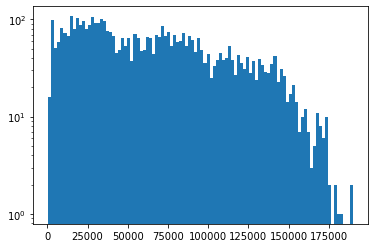

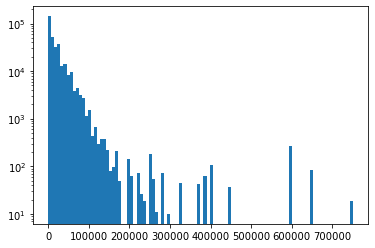

In [37]:
fig, ax = plt.subplots()
ax.hist(sams_distance_matrix.replace(np.inf, -10000).values.flatten(), 100, log=True)
_, ax = plt.subplots()
ax.hist(upsampled_resfil_tours['rf7_km']*1000, 100, log=True)

In [38]:
sams_distance_matrix

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,1264,1266,1267,1272,1273,1275,1276,1277,1278,1280,1281,1282,1283,1284,1285,1286,1287,1290,1291,1292,1293,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,4000.000,58784.132,52200.495,81825.859,93038.044,82323.480,27169.711,20220.946,40074.334,72573.799,87785.103,48005.889,42039.205,111510.657,121240.048,34479.419,64151.871,29270.803,84767.506,59569.604,39851.989,18644.179,47136.591,56600.728,22319.470,104313.499,90590.395,93300.285,121601.763,61901.267,66129.081,71164.415,71164.415,74971.089,74440.998,74932.576,79307.444,73428.722,71127.413,73507.168,84929.066,89744.257,89873.732,67024.055,66912.146,65741.418,56710.909,61496.938,101293.899,95285.781,89440.368,94877.121,93735.560,93217.721,94350.328,100618.368,99500.933,103298.618,105608.033,100066.418,85054.854,102935.751,85060.831,102371.287,109228.928,126244.285,120728.780,101293.899
1230,57588.199,4000.000,9076.159,34659.582,105249.768,104518.658,77749.261,28924.707,22820.228,25407.522,40618.826,46547.069,57467.691,110051.837,134646.311,101773.452,86347.049,78330.072,106962.684,17130.399,12981.293,44880.660,69331.769,78795.906,30253.395,57147.222,43424.118,91841.465,82818.348,84096.445,84617.266,32381.000,32381.000,36187.674,35657.583,36149.161,40524.029,34645.307,32343.998,47647.589,46145.651,50960.842,51090.317,50101.517,46738.112,40196.407,38955.435,40701.288,62510.484,56502.366,50656.953,56093.706,54952.145,54434.306,55566.913,61834.953,60717.518,64515.203,66824.618,61283.003,70665.238,64152.336,64419.722,74540.168,70445.513,79078.008,73562.503,62510.484
1231,51542.694,9739.653,4000.000,32781.380,108277.575,98473.153,71703.756,22879.202,16774.723,23529.320,38740.624,49574.876,60495.498,113079.644,137674.118,95727.947,80301.544,72284.567,100917.179,10435.661,16009.100,38835.155,63286.264,72750.401,33281.202,55269.020,41545.916,94869.272,91394.086,78050.940,87645.073,40956.738,40956.738,44763.412,44233.321,44724.899,49099.767,43221.045,40919.736,56223.327,54721.389,59536.580,59666.055,58677.255,55313.850,48772.145,47531.173,49277.026,76005.842,65078.104,59232.691,64669.444,63527.883,63010.044,64142.651,70410.691,69293.256,73090.941,75400.356,69858.741,79240.976,72728.074,72995.460,83115.906,83900.976,77199.806,71684.301,76005.842
1233,80778.487,33490.815,32266.447,4000.000,136506.250,127708.946,100939.549,52114.995,46010.516,33480.269,48691.573,77803.551,88724.173,141308.319,165902.793,124963.740,109537.337,101520.360,130152.972,24497.307,44237.775,68070.948,92522.057,101986.194,61509.877,65219.969,26538.494,123097.947,114888.807,107286.733,115873.748,64707.900,64707.900,68514.574,67984.483,68476.061,72850.929,66972.207,64670.898,79974.489,78472.551,83287.742,83417.217,82428.417,79065.012,72523.307,71282.335,73028.188,85956.791,82849.009,82983.853,88420.606,87022.604,86761.206,85958.394,94161.853,93044.418,96842.103,98895.077,93353.462,102992.138,96479.236,96746.622,106867.068,93851.925,87150.755,81635.250,85956.791
1256,106291.685,105218.131,107877.843,137464.978,4000.000,59466.989,80956.517,108153.937,107565.405,128212.918,143424.222,60741.189,54294.905,41166.948,43158.062,54492.267,78464.257,79172.655,91305.045,115134.693,94289.182,120842.312,98091.164,107569.844,94574.391,109185.384,146229.514,19231.819,85811.410,96032.978,24827.563,90906.624,90906.624,91092.240,90562.149,91053.727,95428.595,100930.123,98535.414,91086.274,88945.652,79800.677,79082.298,68315.260,84491.252,83320.524,82812.537,79076.044,88374.871,87288.438,84434.349,83297.300,83799.761,83868.158,84414.529,79626.761,74480.698,78620.097,87311.916,84039.763,64532.977,71045.878,67279.478,60658.047,93202.273,98883.011,93499.911,88374.871
1257,83221.733,105680.107,99096.470,12

In [39]:
target_x_sams = all_x_sams.loc[1200:1264].append([all_x_sams.loc[1266:1269], all_x_sams.loc[1271:1299],
                                                  all_x_sams.loc[12650000:12659999],all_x_sams.loc[12700000:12709999],])

In [40]:
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(target_x_sams.loc[:, x_prod.columns])), index=target_x_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, x_att.columns])), index=target_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

In [41]:
pred_prod_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_prod_kommun = pd.DataFrame(production_model.predict(scaler_prod.transform(pred_prod_kommun.loc[:, x_prod.columns])), index=pred_prod_kommun.index, columns=['predicted_production']).sort_index()
pred_attr_kommun = all_x_sams.loc[1200:1299].sort_index()
pred_attr_kommun = pd.DataFrame(attraction_model.predict(scaler_att.transform(pred_attr_kommun.loc[:, x_att.columns])), index=pred_attr_kommun.index, columns=['predicted_attraction']).sort_index()

### Mean trip length from RVU

In [42]:
rvu_mtl = upsampled_resfil_tours['rf7_km'].mean() * 1000
print(rvu_mtl)

20698.241043536986


In [43]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
c=-0.00001
c2 = -0.1
cost_matrix = np.power(f, c2) * np.exp(c*f)
num_iter=10
num_iter_cal = 500
mtl = rvu_mtl
num_zones = len(prodA)
alpha = 0.1
f = f

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
# trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
# trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    model_trip_len = np.nan_to_num(trips * f).sum() / trips.sum()
    c = c*(model_trip_len / mtl)**alpha
    cost_matrix = 0.2 * np.power(f, c2) * np.exp(c * f)
    for _ in range(0, num_iter):
        trips = cost_matrix
        #Run 2D balancing --->
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)
    print ('iteration: ', Iter, ' coefficient: ', c, ' average trip length (model): ', model_trip_len)

print ('target average trip length (observed): ', mtl) 
print ('final average trip length (model): ', model_trip_len)
print ('final logit scaling factor: ', c)

Checking production, attraction balancing:
Production:  379279.37912539067
Attraction:  373030.39418785437
Productions and attractions do not balance, attractions will be scaled to productions!
iteration:  0  coefficient:  -1.0911270632185118e-05  average trip length (model):  49509.29217817411
iteration:  1  coefficient:  -1.188281082094579e-05  average trip length (model):  48570.43505298841
iteration:  2  coefficient:  -1.291429487818311e-05  average trip length (model):  47582.64680731781
iteration:  3  coefficient:  -1.4004452802272033e-05  average trip length (model):  46546.5928202086
iteration:  4  coefficient:  -1.5150615671248436e-05  average trip length (model):  45454.283125520364
iteration:  5  coefficient:  -1.634930742270963e-05  average trip length (model):  44322.497737649406
iteration:  6  coefficient:  -1.759520934406446e-05  average trip length (model):  43140.405452751795
iteration:  7  coefficient:  -1.8882704980823464e-05  average trip length (model):  41940.2616

iteration:  107  coefficient:  -5.185289695644704e-05  average trip length (model):  20700.472144455118
iteration:  108  coefficient:  -5.1853437774219585e-05  average trip length (model):  20700.399939697087
iteration:  109  coefficient:  -5.185393454041371e-05  average trip length (model):  20700.22406147276
iteration:  110  coefficient:  -5.185441828850451e-05  average trip length (model):  20700.17207442767
iteration:  111  coefficient:  -5.18548872875814e-05  average trip length (model):  20700.11317929127
iteration:  112  coefficient:  -5.185534279649346e-05  average trip length (model):  20700.059311101162
iteration:  113  coefficient:  -5.1855698201776984e-05  average trip length (model):  20699.659699882905
iteration:  114  coefficient:  -5.1856020121473924e-05  average trip length (model):  20699.52602433179
iteration:  115  coefficient:  -5.185632949838659e-05  average trip length (model):  20699.47594930448
iteration:  116  coefficient:  -5.185663887714502e-05  average trip

iteration:  231  coefficient:  -5.185936306548114e-05  average trip length (model):  20698.243588309153
iteration:  232  coefficient:  -5.1859363703072785e-05  average trip length (model):  20698.243588309153
iteration:  233  coefficient:  -5.1859364340664436e-05  average trip length (model):  20698.243588309153
iteration:  234  coefficient:  -5.18593649782561e-05  average trip length (model):  20698.243588309153
iteration:  235  coefficient:  -5.185936561584777e-05  average trip length (model):  20698.243588309153
iteration:  236  coefficient:  -5.185936625343945e-05  average trip length (model):  20698.243588309153
iteration:  237  coefficient:  -5.185936689103113e-05  average trip length (model):  20698.243588309153
iteration:  238  coefficient:  -5.1859367528622823e-05  average trip length (model):  20698.243588309153
iteration:  239  coefficient:  -5.185936816621452e-05  average trip length (model):  20698.243588309153
iteration:  240  coefficient:  -5.185936880380623e-05  average

iteration:  365  coefficient:  -5.185944850283147e-05  average trip length (model):  20698.243588309153
iteration:  366  coefficient:  -5.1859449140424165e-05  average trip length (model):  20698.243588309153
iteration:  367  coefficient:  -5.1859449778016866e-05  average trip length (model):  20698.243588309153
iteration:  368  coefficient:  -5.185945041560958e-05  average trip length (model):  20698.243588309153
iteration:  369  coefficient:  -5.18594510532023e-05  average trip length (model):  20698.243588309153
iteration:  370  coefficient:  -5.185945169079503e-05  average trip length (model):  20698.243588309153
iteration:  371  coefficient:  -5.1859452328387764e-05  average trip length (model):  20698.243588309153
iteration:  372  coefficient:  -5.1859452965980506e-05  average trip length (model):  20698.243588309153
iteration:  373  coefficient:  -5.1859453603573254e-05  average trip length (model):  20698.243588309153
iteration:  374  coefficient:  -5.1859454241166016e-05  aver

In [44]:
filtered_resfil_tours = resfil_tours_raw[(resfil_tours_raw.rf1_Samskod > 1) & (resfil_tours_raw.rf4_Samskod > 1)]
filtered_resfil_tours.loc[:,'rf6_ankomsttid'] = filtered_resfil_tours.loc[:,'rf6_ankomsttid'].replace({'99':np.NaN})
filtered_resfil_tours = filtered_resfil_tours.dropna(subset=['rf2_starttid','rf6_ankomsttid', 'rf7_km'])
t1 = filtered_resfil_tours.rf2_starttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t2 = filtered_resfil_tours.rf6_ankomsttid.apply(lambda t: datetime.datetime.strptime(t.strip(),'%H:%M'))
t = t2-t1
t= t.apply(lambda x: x.seconds /60/60)
speed = filtered_resfil_tours.rf7_km / (t)
filtered_resfil_tours['speed'] = speed
filtered_resfil_tours = filtered_resfil_tours[filtered_resfil_tours.speed <= 70]
upsampled_resfil_tours = draw_population(filtered_resfil_tours, filtered_resfil_tours.individvikt.astype(int))

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
f = sams_distance_matrix.values
bins = [0., 7001, 19000, 30000, 50000, 10000000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(filtered_resfil_tours.rf7_km * 1000, bins)
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

array([160131.59937412, 100342.95590303,  64577.91465353,  38623.15469709,
        15603.75449762])

In [46]:
a = 227789 - observed_tld[0]
observed_tld[0] = 227789 + 80000
# observed_tld[1] = observed_tld[1] - a
# observed_tld[2] = observed_tld[2]
observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())
observed_tld

array([221540.84760743,  72225.00967284,  46481.99236835,  27800.23467007,
        11231.29480671])

In [47]:
observed_tld.sum()

379279.3791253906

In [48]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
num_iter=100
num_iter_cal = 500
num_zones = len(prodA)
f = f
alpha = 0.1

# bins = [0., 12000 ,20000,50000,1000000]
# # bins = [_ for _ in range(0, 100000, 7000)]+[1000000]
# binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
# observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
# observed_tld = observed_tld / (sum(observed_tld) / pred_prod_kommun.sum().sum())

cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix*f
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    for i in range(0, 10):
        computed_attractions = trips.sum(0)
        computed_attractions[computed_attractions==0]=1
        trips = trips * (attrT / computed_attractions)
        trips = trips.round(0)

        computed_productions = trips.sum(1)
        computed_productions[computed_productions==0]=1
        trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
        trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    cn = []
    for c in coeff:
        if c > 1:
            cn.append(1+1/c*alpha)
        elif c < 1:
            cn.append(1-c*alpha)
        else:
            cn.append(1)
    coeff = cn
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / matrix_c
    trips = cost_matrix * f
    trips = trips.round(0)
    print(modelled_tld.astype(int))

for i in range(0, 100):
    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
    trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
    trips = trips.round(0)
    
print(modelled_tld.astype(int))
print('observed tld')
print(observed_tld.astype(int))

Checking production, attraction balancing:
Production:  379279.37912539067
Attraction:  373030.39418785437
Productions and attractions do not balance, attractions will be scaled to productions!
[  5413   6344  32822  46399 288339]
[  5366   6367  34838  44435 288319]
[  5328   6355  36986  42419 288239]
[  5274   6364  39327  40326 288034]
[  5204   6343  41925  38145 287707]
[  5078   6324  44778  35995 287153]
[  4990   6301  47898  33662 286479]
[  5206   6579  45969  32518 289056]
[  5126   6506  49223  30210 288268]
[  5343   6829  47364  28909 290881]
[  5598   7133  45524  27603 293470]
[  5360   6905  47628  29205 290233]
[  5648   7205  45801  27869 292807]
[  5509   7195  48997  25565 292060]
[  5636   7337  46169  27941 292244]
[  5555   7260  49414  25594 291505]
[  5653   7412  46643  27961 291652]
[  5956   7775  44753  26583 294260]
[  5676   7555  46845  28126 291120]
[  5968   7883  44938  26785 293753]
[  5710   7669  47052  28312 290581]
[  5964   8032  45187  26988 

[ 21467  70381  48297  29912 209213]
[ 22446  73077  45768  27906 210075]
[ 22204  71412  49424  25900 210333]
[ 22841  73387  46205  27963 208880]
[ 22575  71715  49873  25986 209126]
[ 23249  73740  46722  28048 207523]
[ 24087  72555  44613  26718 211297]
[ 23469  70129  47377  28979 209319]
[ 24541  72817  44809  26973 210133]
[ 23915  70334  47564  29269 208188]
[ 24970  73083  45016  27176 209028]
[ 24373  70682  47824  29542 206852]
[ 25480  73368  45236  27533 207656]
[ 24810  70909  48045  29915 205594]
[ 25949  73609  45519  27914 206290]
[ 25696  71990  49081  25860 206647]
[ 26451  74011  45862  27924 205028]
[ 26156  72291  49490  25927 205404]
[ 26747  70352  46774  28754 206644]
[ 27925  73120  44100  26734 207397]
[ 27320  70708  46876  29001 205374]
[ 28524  73405  44228  26949 206175]
[ 27907  71006  46983  29257 204124]
[ 29154  73707  44329  27201 204885]
[ 28484  71295  47087  29573 202837]
[ 29794  74093  44446  27492 203454]
[ 29123  71570  47221  29908 201452]
[

In [49]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,1264,1266,1267,1272,1273,1275,1276,1277,1278,1280,1281,1282,1283,1284,1285,1286,1287,1290,1291,1292,1293,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
1214,525,1,1,4,5,3,57,126,29,1,1,31,26,6,5,26,1,55,4,43,380,2362,149,2,256,2,4,14,2,3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1230,0,118,105,13,1,1,0,36,18,13,2,8,0,1,2,1,0,0,1,5003,1783,16,4,1,13,0,15,5,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1231,0,67,139,9,1,1,0,25,150,10,2,7,0,1,1,1,0,0,1,2575,1857,12,3,1,12,0,12,4,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1233,2,38,49,3633,9,11,3,4,67,28,32,3,4,11,13,10,2,6,12,5264,827,8,26,6,8,2,439,29,4,13,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1256,2,2,2,16,1838,3,3,5,2,2,2,1,2,87,87,3,2,2,5,236,86,16,32,4,15,3,16,916,2,15,676,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
trips.sum().sum()

379341

In [51]:
sum(observed_tld)

379279.3791253906

### All trips after gravity vs predicted attraction / production

In [52]:
tours_incomming_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf1_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf1_komkod'] < 100) )
                          ].groupby('rf4_komkod')['Id'].count().loc[1200:1299]
tours_outgoing_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf4_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf4_komkod'] < 100) )
                          ].groupby('rf1_komkod')['Id'].count().loc[1200:1299]

In [53]:
def get_kommun(trips, code):
    return pd.DataFrame([[trips.loc[code, 1200:code-1].sum().sum() + trips.loc[code, code+1:1299].sum().sum(),
                         trips.loc[1200:code-1, code].sum().sum() + trips.loc[code+1:1299, code].sum().sum(),
                         trips.loc[code, code].sum().sum()
                        ]], index=[code], columns=['outgoing', 'incomming', 'within'])

In [54]:
gravity_tours = pd.concat([get_kommun(trips, code) for code in trips.index[trips.index < 1299]])

In [55]:
gravity_tours = pd.concat([
gravity_tours,
pd.DataFrame([[trips.loc[12650000:12659999, 1200:1299].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[1200:1299, 12650000:12659999].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[12650000:12659999, 12650000:12659999].sum().sum()
                        ]], index=[1265], columns=['outgoing', 'incomming', 'within']),
pd.DataFrame([[trips.loc[12700000:12709999, 1200:1299].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[1200:1299, 12700000:12709999].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[12700000:12709999, 12700000:12709999].sum().sum()
                        ]], index=[1270], columns=['outgoing', 'incomming', 'within']),
])

In [56]:
gravity_tours['outgoing'] = gravity_tours['outgoing'] + tours_outgoing_from_external.reindex(index=gravity_tours.index, fill_value=0)
gravity_tours['incomming'] = gravity_tours['incomming'] + tours_incomming_from_external.reindex(index=gravity_tours.index, fill_value=0)

In [57]:
gravity_tours.within.sum()

220889

In [58]:
other_trip_scb.within.sum()

227789.40889674125

In [59]:
gravity_tours.sum().sum()

530624

In [60]:
other_trip_scb.sum()['production'].sum()

376943.0000000002

In [61]:
trips.sum().sum()

379341

In [62]:
gravity_tours.sum().sum()

530624

In [63]:
other_trip_scb.sum()[['outgoing', 'incomming', 'within']].sum()

519080.8925219132

In [64]:
pd.concat([gravity_tours, other_trip_scb], axis=1)

,outgoing,incomming,within,production,attraction,outgoing,incomming,within
1214,3606,2219,525,4183.918576,2605.663339,2611.962458,1033.707222,1571.956117
1230,7046,4295,118,7242.901303,4117.234794,5506.733658,2381.067149,1736.167645
1231,4756,5349,139,4871.825861,5380.534059,3584.633385,4093.341582,1287.192476
1233,6949,2347,3633,10507.800073,5538.229256,7291.556571,2321.985753,3216.243503
1256,2245,1235,1838,4092.472738,3159.551428,1897.121007,964.199697,2195.351731
1257,1581,1261,1350,2904.328485,2530.291117,1244.836328,870.798960,1659.492156
1260,3842,2925,494,4306.860010,3130.227941,2633.031927,1456.399857,1673.828083
1261,7610,3857,1999,9405.236960,5173.966383,6505.035485,2273.764908,2900.201476
1262,6551,3864,346,6822.597989,3601.575844,5277.576037,2056.553892,1545.021951
1263,6076,3538,496,6524.367265,4400.260747,4674.598259,2550.491741,1849.769006


In [65]:
(other_trip_scb[['incomming', 'outgoing', 'within']] / gravity_tours).describe()

,incomming,outgoing,within
count,33.000000,33.000000,33.000000
mean,0.995042,0.960082,2.448789
std,1.042335,0.354360,2.842552
min,0.327573,0.533459,0.833259
25%,0.566949,0.724338,0.935152
50%,0.720885,0.837814,1.228536
75%,1.075922,1.089713,3.388316
max,6.458408,1.997374,14.713285


In [66]:
(other_trip_scb[['outgoing', 'incomming', 'within']].loc[[1265,1270]] / gravity_tours.loc[[1265,1270]]).describe()

,outgoing,incomming,within
count,2.000000,2.000000,2.000000
mean,0.839594,0.754114,1.097177
std,0.002517,0.102938,0.059499
min,0.837814,0.681325,1.055105
25%,0.838704,0.717720,1.076141
50%,0.839594,0.754114,1.097177
75%,0.840484,0.790508,1.118213
max,0.841374,0.826902,1.139250


In [67]:
trips.loc[12650000:12659999]

,1214,1230,1231,1233,1256,1257,1260,1261,1262,1263,1264,1266,1267,1272,1273,1275,1276,1277,1278,1280,1281,1282,1283,1284,1285,1286,1287,1290,1291,1292,1293,12650001,12650002,12650003,12650004,12650005,12650006,12650007,12650008,12650009,12650010,12650011,12650012,12650013,12650014,12650015,12650016,12650017,12700001,12700002,12700003,12700004,12700005,12700006,12700007,12700008,12700009,12700010,12700011,12700012,12700013,12700014,12700015,12700016,12700017,12700018,12700019,12700020
12650001,0,2,3,1,1,1,0,0,0,0,5,2,3,1,1,0,0,0,1,95,32,1,4,1,1,14,1,3,0,1,2,0,0,22,25,36,0,4,6,6,0,0,0,0,6,0,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650002,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,14,4,0,1,0,0,2,0,1,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650003,1,13,20,3,4,5,3,3,1,1,7,57,18,4,5,3,2,2,5,21,210,3,13,3,3,72,3,10,29,5,6,12,10,99,20,34,8,25,25,16,6,20,43,50,47,9,18,18,6,0,16,5,15,8,4,0,4,5,0,5,0,0,4,4,0,0,0,0
12650004,1,7,12,2,3,3,2,1,1,1,3,34,12,3,3,2,1,1,3,12,115,3,8,2,2,41,3,7,16,4,4,7,10,8,71,22,4,15,14,9,5,11,22,24,22,7,9,10,4,0,8,5,6,4,4,0,4,5,0,5,0,0,4,4,0,0,0,0
12650005,1,6,10,1,3,3,1,1,1,1,3,30,8,3,3,1,1,1,3,10,100,2,7,1,1,35,2,6,13,3,3,7,0,10,14,68,4,13,10,9,0,9,16,24,19,3,9,9,4,0,8,0,6,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650006,0,2,3,1,1,1,0,0,0,0,2,2,3,1,1,0,0,0,1,4,35,1,3,1,1,96,1,3,0,1,2,0,0,19,22,25,2,2,3,4,0,4,7,0,0,3,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650007,1,5,8,2,2,3,1,1,1,5,86,7,1,2,3,1,1,1,3,7,78,2,7,2,2,259,18,6,1,3,3,4,0,34,44,54,2,10,17,0,0,0,0,5,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650008,0,3,4,1,1,1,0,0,0,3,5,3,0,1,1,0,0,0,2,135,44,1,5,1,1,15,1,4,0,1,2,0,0,20,20,22,2,8,6,0,0,0,0,0,0,4,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12650009,0,4,0,1,1,2,1,1,0,0,0,15,5,1,1,1,1,1,2,6,67,1,5,1,1,4,1,3,8,2,3,3,0,12,14,20,1,1,0,9,0,4,13,5,5,3,4,4,0,0,5,11,4,0,0,0,4,6,0,0,0,0,4,4,0,0,0,0
12650010,0,1,0,1,0,1,0,0,0,0,1,2,0,0,1,0,0,0,1,2,20,1,2,1,1,5,1,2,1,1,1,0,0,5,5,8,0,0,0,0,0,0,2,0,0,2,0,0,2,0,0,2,6,2,4,0,0,2,0,2,0,0,0,0,0,0,0,0


In [68]:
trips.to_csv('data/cheat_od.csv', index=True, header=True)

### SCB pendlare

In [69]:
scb_pendlare = pd.read_csv('data/SCB_OD_matrix_2014.csv', sep=';').groupby(['Kommunkod', 'kommunkod'])['TOTAL'].sum().loc[1200:1299].unstack().loc[:,1200:1299]

In [70]:
pd.concat([scb_pendlare[1265], trips.loc[12650001:12650099].sum()], axis=1)

,1265,0
1214,6.0,7.0
1230,32.0,57.0
1231,23.0,73.0
1233,13.0,21.0
1256,1.0,23.0
1257,0.0,28.0
1260,7.0,12.0
1261,28.0,14.0
1262,12.0,7.0
1263,26.0,14.0


In [71]:
trips.loc[12650001:12650099].sum().loc[12650001:12650099].sum()

2352

In [72]:
pd.DataFrame((scb_pendlare / trips).values.flatten()).describe()

,0
count,961.000000
mean,inf
std,NaN
min,0.000000
25%,0.500000
50%,1.450046
75%,4.333333
max,inf


In [73]:
r2_score(scb_pendlare, trips)

ValueError: Found input variables with inconsistent numbers of samples: [33, 68]

In [ ]:
fig, ax = plt.subplots()
ax.hist((scb_pendlare / trips).values.flatten(), bins=[i for i in np.arange(0.,2.,0.1)])

In [ ]:
(scb_pendlare - trips).loc[[1265,1270,1280,1264,1291,1231,1214,1275,1233,1231], [1265,1270,1280,1264,1291,1231,1214,1275,1233,1231]]